---
# **Imports**
---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

---
# **Data Setup**
---

In [2]:
raw_data = pd.read_csv('../data/raw_data.csv',
                       index_col='Date', 
                       parse_dates=['Date'])

df = raw_data.copy()
print(f'The total data include {df.shape[0]} observations')
df.tail()

The total data include 2516 observations


,AAPL,PG,S&P500
Date,,,
2023-12-22,191.788788,138.102371,4754.629883
2023-12-26,191.243927,138.729767,4774.750000
2023-12-27,191.342972,138.843811,4781.580078
2023-12-28,191.768951,138.530136,4783.350098
2023-12-29,190.728760,139.300110,4769.830078


### **Filtering the data to 5 and 10 year period**

In [3]:
# Take the last 5 year period
start_date_short = '2019-01-02'
end_date_short = '2023-12-29'

# Take the last 10 year period
start_date_long = '2014-01-02'
end_date_long = '2023-12-29'

# Filter the DataFrame 5-year
short_df = df.loc[(df.index >= start_date_short) & (df.index <= end_date_short)]

# Filter the DataFrame 10-year
long_df = df.loc[(df.index >= start_date_long) & (df.index <= end_date_long)]

# Saving the data to a csv file
short_df.to_csv('../data/five_year_data.csv')
long_df.to_csv('../data/ten_year_data.csv')

# =============================
# Basic Descriptive Statistic
# =============================

# 5-Year
print('Data: 5-year period')
display(short_df.describe().round(1))

# 10-year
print('\nData: 10-year period')
display(long_df.describe().round(1))

Data: 5-year period


,AAPL,PG,S&P500
count,1258.0,1258.0,1258.0
mean,120.4,121.0,3755.8
std,46.4,18.4,634.1
min,33.8,75.9,2237.4
25%,74.7,106.0,3128.7
50%,131.4,123.0,3907.4
75%,156.7,136.9,4305.1
max,196.3,149.5,4796.6



Data: 10-year period


,AAPL,PG,S&P500
count,2516.0,2516.0,2516.0
mean,75.3,92.9,3005.9
std,56.2,31.3,901.3
min,15.5,51.2,1741.9
25%,27.0,64.2,2124.3
50%,45.7,77.9,2798.2
75%,131.4,123.0,3907.1
max,196.3,149.5,4796.6


---
# **Calculating Stock Volatility**
---

### **Initialization**

In [4]:
# Filter the DataFrame
return_df = df.loc[(df.index >= start_date_long) & (df.index <= end_date_long)]

# Calculate daily returns
returns = return_df.pct_change().dropna()

### **Calculate Annualized Volatility (σ)**

In [5]:
def annualized_volatility(returns):
    return returns.std() * np.sqrt(252)

volatility = annualized_volatility(returns)
print("=== ANNUALIZED VOLATILITY (σ) ===")
print(f"AAPL Volatility: {volatility['AAPL']:.4f} ({volatility['AAPL']*100:.2f}%)")
print(f"PG Volatility: {volatility['PG']:.4f} ({volatility['PG']*100:.2f}%)")
print(f"Difference: {(volatility['AAPL'] - volatility['PG'])*100:.2f}%")

=== ANNUALIZED VOLATILITY (σ) ===
AAPL Volatility: 0.2838 (28.38%)
PG Volatility: 0.1823 (18.23%)
Difference: 10.15%


### **Calculate TRUE Beta (β) - using S&P500 as market benchmark**

In [6]:
def calculate_beta(stock_returns, market_returns):
    covariance = np.cov(stock_returns, market_returns)[0,1]
    market_variance = np.var(market_returns)
    return covariance / market_variance

beta_aapl = calculate_beta(returns['AAPL'], returns['S&P500'])
beta_pg = calculate_beta(returns['PG'], returns['S&P500'])

print("=== TRUE BETA (β) COEFFICIENTS (vs S&P500) ===")
print(f"AAPL Beta: {beta_aapl:.4f}")
print(f"PG Beta: {beta_pg:.4f}")

=== TRUE BETA (β) COEFFICIENTS (vs S&P500) ===
AAPL Beta: 1.1904
PG Beta: 0.5756


---
# **Apple(AAPL) Stock | 5 Year Period**</span>
---

### **AAPL: Data Initialization**

In [7]:
# Use AAPL closing price
aapl_price = short_df['AAPL']

# Create AUTOREGRESSIVE features (using past prices to predict future)
aapl_data = pd.DataFrame()
aapl_data['lag_1'] = aapl_price.shift(1) # Yesterday's price
aapl_data['lag_2'] = aapl_price.shift(2) # Day before yesterday's price
aapl_data['lag_3'] = aapl_price.shift(3) # 3 days ago price

# Adding rolling features to capture volatility
aapl_data['rolling_mean_5'] = aapl_price.shift(1).rolling(window=5).mean()
aapl_data['rolling_std_5'] = aapl_price.shift(1).rolling(window=5).std()
aapl_data['rolling_mean_10'] = aapl_price.shift(1).rolling(window=10).mean()
aapl_data['rolling_std_10'] = aapl_price.shift(1).rolling(window=10).std()

# Adding percentage change features
aapl_data['pct_change_1'] = aapl_price.pct_change().shift(2)  # shift(2) because pct_change uses current and previous
aapl_data['pct_change_5'] = aapl_price.pct_change(5).shift(2)

# Target feature
aapl_data['Target'] = aapl_price.shift(-1) # Predict TOMORROW'S price

# Remove rows with missing values
aapl_data = aapl_data.dropna()
aapl_data.head(11)

,lag_1,lag_2,lag_3,rolling_mean_5,rolling_std_5,rolling_mean_10,rolling_std_10,pct_change_1,pct_change_5,Target
Date,,,,,,,,,,
2019-01-16,36.385937,35.656162,36.200523,36.249014,0.355870,35.882468,1.010371,-0.015037,0.013993,37.049145
2019-01-17,36.830460,36.385937,35.656162,36.326508,0.440738,35.811633,0.900166,0.020467,0.015390,37.277336
2019-01-18,37.049145,36.830460,36.385937,36.424445,0.547033,36.136579,0.642934,0.012217,0.010632,36.440605
2019-01-22,37.277336,37.049145,36.830460,36.639808,0.640772,36.340057,0.650496,0.005938,0.013394,36.587994
2019-01-23,36.440605,37.277336,37.049145,36.796696,0.384516,36.467707,0.502506,0.006159,0.029746,36.297985
2019-01-24,36.587994,36.440605,37.277336,36.837108,0.338407,36.543061,0.450837,-0.022446,0.022000,37.500782
2019-01-25,36.297985,36.587994,36.440605,36.730613,0.415927,36.528561,0.456707,0.004045,0.005553,37.153736
2019-01-28,37.500782,36.297985,36.587994,36.820940,0.534529,36.622693,0.551048,-0.007926,-0.014457,36.768642
2019-01-29,37.153736,37.500782,36.297985,36.796220,0.510461,36.718014,0.552349,0.033137,0.012190,39.281216


### **AAPL: Split the Data**

In [8]:
# Prepare feature and target
X_aapl = aapl_data.drop('Target', axis=1)
y_aapl = aapl_data['Target']

# Time-based split (75%/25% split in accordance with the paper)
split_point_aapl = int(len(X_aapl) * 0.75)
X_train_aapl, X_test_aapl = X_aapl[:split_point_aapl], X_aapl[split_point_aapl:]
y_train_aapl, y_test_aapl = y_aapl[:split_point_aapl], y_aapl[split_point_aapl:]

# Scale features for LASSO and ElasticNet
scaler = StandardScaler()
X_train_scaled_aapl = scaler.fit_transform(X_train_aapl)
X_test_scaled_aapl = scaler.transform(X_test_aapl)

print(f"Train set size: {X_train_aapl.shape}")
print(f"Test set size: {X_test_aapl.shape}")

Train set size: (935, 9)
Test set size: (312, 9)


### **Modeling (AAPL): RandomForest, XGBoost, ElasticNet, LASSO**

In [9]:
# List of all the models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=0),
    'LASSO': Lasso(alpha=0.01, random_state=0),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=0),
}

# Store results
results = {}
predictions = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled_aapl, y_train_aapl)
    y_pred_aapl = model.predict(X_test_scaled_aapl)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_aapl, y_pred_aapl)
    rmse = np.sqrt(mean_squared_error(y_test_aapl, y_pred_aapl))
    r2 = r2_score(y_test_aapl, y_pred_aapl)
    mape = np.mean(np.abs((y_test_aapl - y_pred_aapl) / y_test_aapl)) * 100
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE (%)': mape
    }
    
    predictions[name] = y_pred_aapl

Training Random Forest...
Training XGBoost...
Training LASSO...
Training ElasticNet...


### **AAPL: Results Analysis**

In [10]:
# Convert results to DataFrame for better display
results_df = pd.DataFrame(results).T
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON AAPL 5 YEARS")
print("="*50)
print(results_df.round(2))


MODEL PERFORMANCE COMPARISON AAPL 5 YEARS
                MAE   RMSE    R²  MAPE (%)
Random Forest  7.27  10.13  0.74      4.14
XGBoost        7.54  10.27  0.73      4.32
LASSO          2.71   3.53  0.97      1.70
ElasticNet     3.00   3.77  0.96      1.88


### **AAPL: Visual Graph Result**

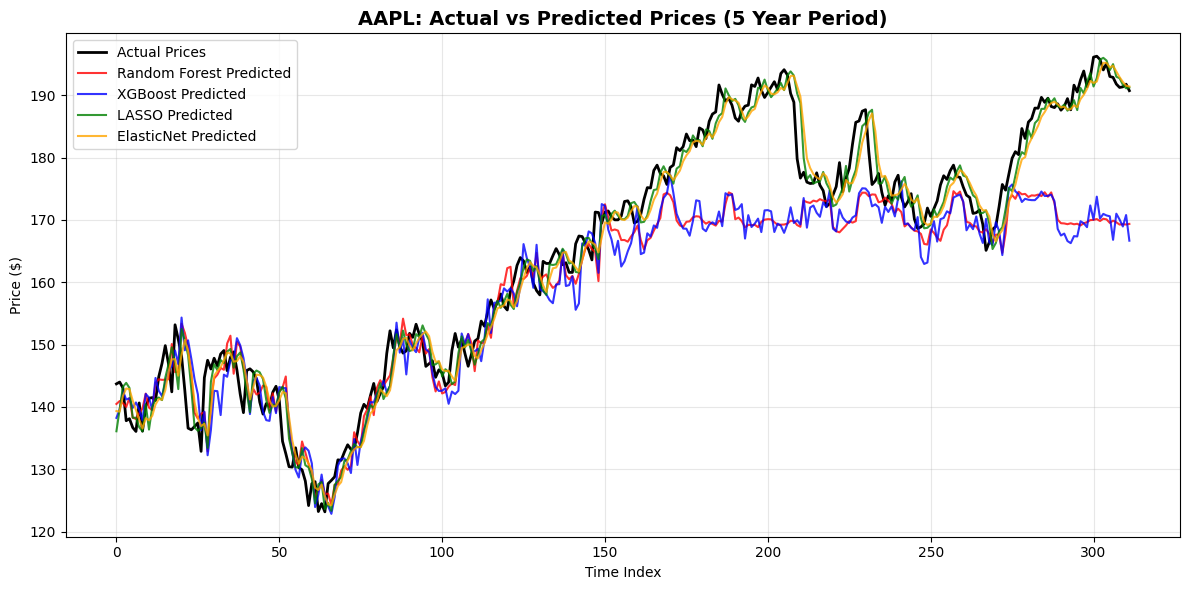

In [11]:
plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(y_test_aapl.to_numpy(), label='Actual Prices', color='black', linewidth=2)

# Plot predictions for each model
colors = ['red', 'blue', 'green', 'orange']
for i, (name, pred) in enumerate(predictions.items()):
    plt.plot(pred, label=f'{name} Predicted', color=colors[i], alpha=0.8, linewidth=1.5)

plt.title('AAPL: Actual vs Predicted Prices (5 Year Period)', fontsize=14, fontweight='bold')
plt.xlabel('Time Index')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# **Procter & Gamble(PG) Stock | 5 Year Period**
---

### **P&G: Data Initialization**

In [12]:
# Use P&G closing price
pg_price = short_df['PG']

# Create AUTOREGRESSIVE features (using past prices to predict future)
pg_data = pd.DataFrame()
pg_data['lag_1'] = pg_price.shift(1) # Yesterday's price
pg_data['lag_2'] = pg_price.shift(2) # Day before yesterday's price
pg_data['lag_3'] = pg_price.shift(3) # 3 days ago price

# Adding rolling features to capture volatility
pg_data['rolling_mean_5'] = pg_price.shift(1).rolling(window=5).mean()
pg_data['rolling_std_5'] = pg_price.shift(1).rolling(window=5).std()
pg_data['rolling_mean_10'] = pg_price.shift(1).rolling(window=10).mean()
pg_data['rolling_std_10'] = pg_price.shift(1).rolling(window=10).std()

# Adding percentage change features
pg_data['pct_change_1'] = pg_price.pct_change().shift(2)  # shift(2) because pct_change uses current and previous
pg_data['pct_change_5'] = pg_price.pct_change(5).shift(2)

# Target feature
pg_data['Target'] = pg_price.shift(-1) # Predict TOMORROW'S price

# Remove rows with missing values
pg_data = pg_data.dropna()
pg_data.head(11)

,lag_1,lag_2,lag_3,rolling_mean_5,rolling_std_5,rolling_mean_10,rolling_std_10,pct_change_1,pct_change_5,Target
Date,,,,,,,,,,
2019-01-16,77.066101,76.345741,76.865067,76.563525,0.380726,76.726012,0.546602,-0.006756,-0.010530,76.519058
2019-01-17,76.529999,77.066101,76.345741,76.633881,0.319268,76.733549,0.542951,0.009435,-0.004867,77.177505
2019-01-18,76.519058,76.529999,77.066101,76.665193,0.292557,76.793597,0.471279,-0.006956,0.004618,76.350197
2019-01-22,77.177505,76.519058,76.529999,76.727681,0.369239,76.764536,0.432422,-0.000143,0.002050,80.064720
2019-01-23,76.350197,77.177505,76.519058,76.728572,0.368090,76.683736,0.426135,0.008605,0.004065,79.608871
2019-01-24,80.064720,76.350197,77.177505,77.328296,1.562016,76.945911,1.145114,-0.010720,0.000058,79.017899
2019-01-25,79.608871,80.064720,76.350197,77.944070,1.762628,77.288976,1.379479,0.048651,0.038910,78.950363
2019-01-28,79.017899,79.608871,80.064720,78.443839,1.604762,77.554516,1.435748,-0.005694,0.040231,78.967247
2019-01-29,78.950363,79.017899,79.608871,78.798410,1.442689,77.763046,1.475374,-0.007423,0.032656,79.794563


### **P&G: Split the Data**

In [13]:
# Prepare feature and target
X_pg = pg_data.drop('Target', axis=1)
y_pg = pg_data['Target']

# Time-based split (75%/25% split in accordance with the paper)
split_point_pg = int(len(X_pg) * 0.75)
X_train_pg, X_test_pg = X_pg[:split_point_pg], X_pg[split_point_pg:]
y_train_pg, y_test_pg = y_pg[:split_point_pg], y_pg[split_point_pg:]

# Scale features for LASSO and ElasticNet
X_train_scaled_pg = scaler.fit_transform(X_train_pg)
X_test_scaled_pg = scaler.transform(X_test_pg)

print(f"Train set size: {X_train_pg.shape}")
print(f"Test set size: {X_test_pg.shape}")

Train set size: (935, 9)
Test set size: (312, 9)


### **Modeling (P&G): RandomForest, XGBoost, ElasticNet, LASSO**

In [14]:
# List of all the models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=0),
    'LASSO': Lasso(alpha=0.01, random_state=0),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=0),
}

# Store results
results_pg = {}
predictions_pg = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for LASSO and SVM, raw for tree-based models
    if name in ['ElasticNet', 'LASSO']:
        model.fit(X_train_scaled_pg, y_train_pg)
        y_pred_pg = model.predict(X_test_scaled_pg)
    else:
        model.fit(X_train_pg, y_train_pg)
        y_pred_pg = model.predict(X_test_pg)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_pg, y_pred_pg)
    rmse = np.sqrt(mean_squared_error(y_test_pg, y_pred_pg))
    r2 = r2_score(y_test_pg, y_pred_pg)
    mape = np.mean(np.abs((y_test_pg - y_pred_pg) / y_test_pg)) * 100
    
    results_pg[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE (%)': mape
    }
    
    predictions_pg[name] = y_pred_pg

Training Random Forest...
Training XGBoost...
Training LASSO...
Training ElasticNet...


### **P&G: Results Analysis**

In [15]:
# Convert results to DataFrame for better display
results_df_pg = pd.DataFrame(results_pg).T
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON P&G 5 YEARS")
print("="*50)
print(results_df_pg.round(2))


MODEL PERFORMANCE COMPARISON P&G 5 YEARS
                MAE  RMSE    R²  MAPE (%)
Random Forest  1.75  2.22  0.91      1.27
XGBoost        2.05  2.55  0.88      1.50
LASSO          1.51  1.92  0.93      1.10
ElasticNet     1.61  2.03  0.93      1.18


### **P&G: Visual Graph Result**

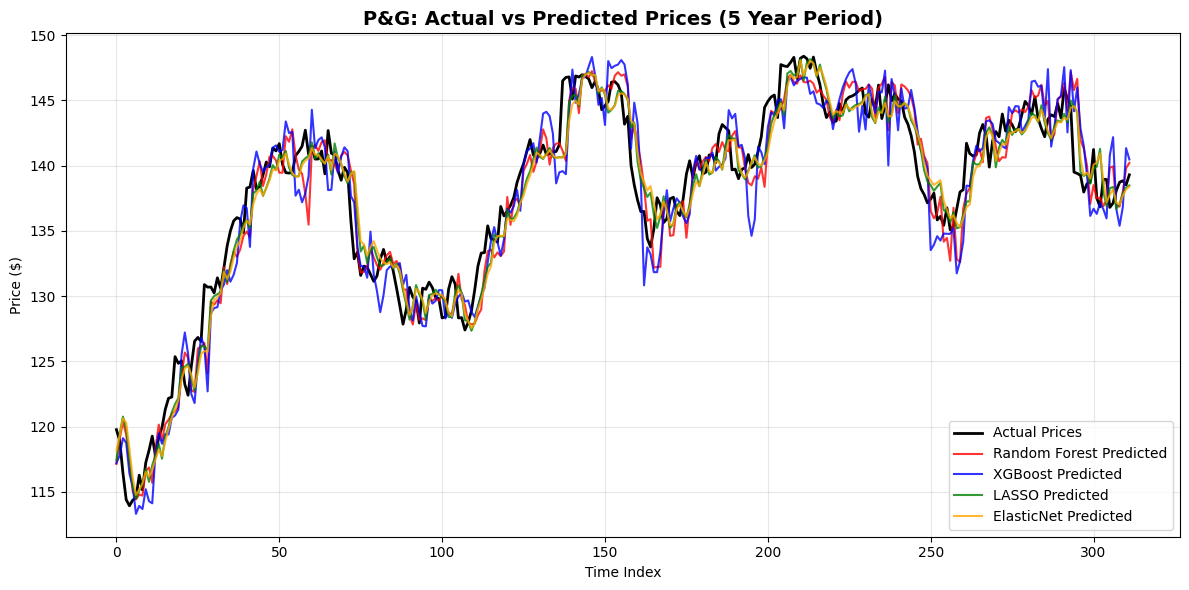

In [16]:
plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(y_test_pg.to_numpy(), label='Actual Prices', color='black', linewidth=2)

# Plot predictions for each model
colors = ['red', 'blue', 'green', 'orange']
for i, (name, pred) in enumerate(predictions_pg.items()):
    plt.plot(pred, label=f'{name} Predicted', color=colors[i], alpha=0.8, linewidth=1.5)

plt.title('P&G: Actual vs Predicted Prices (5 Year Period)', fontsize=14, fontweight='bold')
plt.xlabel('Time Index')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# **Apple(AAPL) Stock | 10 Year Period**
---

### **AAPL: Data Initialization**

In [17]:
# Use AAPL closing price
aapl_price = long_df['AAPL']

# Create AUTOREGRESSIVE features (using past prices to predict future)
aapl_data = pd.DataFrame()
aapl_data['lag_1'] = aapl_price.shift(1) # Yesterday's price
aapl_data['lag_2'] = aapl_price.shift(2) # Day before yesterday's price
aapl_data['lag_3'] = aapl_price.shift(3) # 3 days ago price

# Adding rolling features to capture volatility
aapl_data['rolling_mean_5'] = aapl_price.shift(1).rolling(window=5).mean()
aapl_data['rolling_std_5'] = aapl_price.shift(1).rolling(window=5).std()
aapl_data['rolling_mean_10'] = aapl_price.shift(1).rolling(window=10).mean()
aapl_data['rolling_std_10'] = aapl_price.shift(1).rolling(window=10).std()

# Adding percentage change features
aapl_data['pct_change_1'] = aapl_price.pct_change().shift(2)  # shift(2) because pct_change uses current and previous
aapl_data['pct_change_5'] = aapl_price.pct_change(5).shift(2)

# Target feature
aapl_data['Target'] = aapl_price.shift(-1) # Predict TOMORROW'S price

# Remove rows with missing values
aapl_data = aapl_data.dropna()
aapl_data.head(11)

,lag_1,lag_2,lag_3,rolling_mean_5,rolling_std_5,rolling_mean_10,rolling_std_10,pct_change_1,pct_change_5,Target
Date,,,,,,,,,,
2014-01-16,17.287912,16.947643,16.617002,16.804903,0.312650,16.843984,0.238086,0.019898,0.011758,16.770227
2014-01-17,17.191441,17.287912,16.947643,16.914891,0.336610,16.847458,0.243350,0.020078,0.025578,17.030771
2014-01-21,16.770227,17.191441,17.287912,16.962845,0.280564,16.846497,0.243666,-0.005580,0.033046,17.106457
2014-01-22,17.030771,16.770227,17.191441,17.045599,0.203488,16.862440,0.250589,-0.024501,0.014505,17.251308
2014-01-23,17.106457,17.030771,16.770227,17.077362,0.196656,16.898017,0.258103,0.015536,0.024900,16.937719
2014-01-24,17.251308,17.106457,17.030771,17.070041,0.187318,16.937472,0.280297,0.004444,0.009371,17.075123
2014-01-27,16.937719,17.251308,17.106457,17.019297,0.180450,16.967094,0.260497,0.008468,-0.002117,15.710360
2014-01-28,17.075123,16.937719,17.251308,17.080276,0.114823,17.021560,0.211365,-0.018178,-0.014759,15.532003
2014-01-29,15.710360,17.075123,16.937719,16.816193,0.628144,16.930896,0.456491,0.008112,0.018181,15.501918


### **AAPL: Split the Data**

In [18]:
# Prepare feature and target
X_aapl = aapl_data.drop('Target', axis=1)
y_aapl = aapl_data['Target']

# Time-based split (75%/25% split in accordance with the paper)
split_point_aapl = int(len(X_aapl) * 0.75)
X_train_aapl, X_test_aapl = X_aapl[:split_point_aapl], X_aapl[split_point_aapl:]
y_train_aapl, y_test_aapl = y_aapl[:split_point_aapl], y_aapl[split_point_aapl:]

# Scale features for LASSO and ElasticNet
scaler = StandardScaler()
X_train_scaled_aapl = scaler.fit_transform(X_train_aapl)
X_test_scaled_aapl = scaler.transform(X_test_aapl)

print(f"Train set size: {X_train_aapl.shape}")
print(f"Test set size: {X_test_aapl.shape}")

Train set size: (1878, 9)
Test set size: (627, 9)


### **Modeling (AAPL): RandomForest, XGBoost, ElasticNet, LASSO**

In [19]:
# List of all the models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=0),
    'LASSO': Lasso(alpha=0.01, random_state=0),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=0),
}

# Store results
results = {}
predictions = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled_aapl, y_train_aapl)
    y_pred_aapl = model.predict(X_test_scaled_aapl)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_aapl, y_pred_aapl)
    rmse = np.sqrt(mean_squared_error(y_test_aapl, y_pred_aapl))
    r2 = r2_score(y_test_aapl, y_pred_aapl)
    mape = np.mean(np.abs((y_test_aapl - y_pred_aapl) / y_test_aapl)) * 100
    
    results[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE (%)': mape
    }
    
    predictions[name] = y_pred_aapl

Training Random Forest...
Training XGBoost...
Training LASSO...
Training ElasticNet...


### **AAPL: Results Analysis**

In [20]:
# Convert results to DataFrame for better display
results_df = pd.DataFrame(results).T
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON AAPL 10 YEARS")
print("="*50)
print(results_df.round(2))


MODEL PERFORMANCE COMPARISON AAPL 10 YEARS
                 MAE   RMSE    R²  MAPE (%)
Random Forest  26.79  31.64 -2.38     15.92
XGBoost        27.74  32.48 -2.56     16.53
LASSO           2.99   3.84  0.95      1.92
ElasticNet      3.31   4.19  0.94      2.12


### **AAPL: Visual Graph Result**

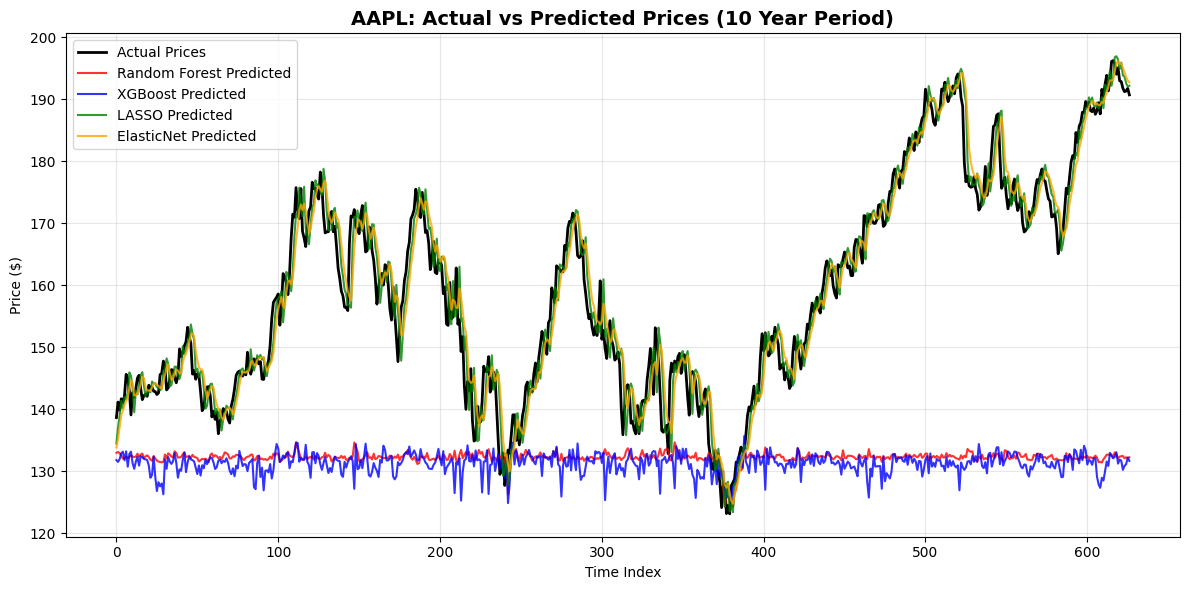

In [21]:
plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(y_test_aapl.to_numpy(), label='Actual Prices', color='black', linewidth=2)

# Plot predictions for each model
colors = ['red', 'blue', 'green', 'orange']
for i, (name, pred) in enumerate(predictions.items()):
    plt.plot(pred, label=f'{name} Predicted', color=colors[i], alpha=0.8, linewidth=1.5)

plt.title('AAPL: Actual vs Predicted Prices (10 Year Period)', fontsize=14, fontweight='bold')
plt.xlabel('Time Index')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
# **Procter & Gamble(PG) Stock | 10 Year Period**
---

### **P&G: Data Initialization**

In [22]:
# Use P&G closing price
pg_price = long_df['PG']

# Create AUTOREGRESSIVE features (using past prices to predict future)
pg_data = pd.DataFrame()
pg_data['lag_1'] = pg_price.shift(1) # Yesterday's price
pg_data['lag_2'] = pg_price.shift(2) # Day before yesterday's price
pg_data['lag_3'] = pg_price.shift(3) # 3 days ago price

# Adding rolling features to capture volatility
pg_data['rolling_mean_5'] = pg_price.shift(1).rolling(window=5).mean()
pg_data['rolling_std_5'] = pg_price.shift(1).rolling(window=5).std()
pg_data['rolling_mean_10'] = pg_price.shift(1).rolling(window=10).mean()
pg_data['rolling_std_10'] = pg_price.shift(1).rolling(window=10).std()

# Adding percentage change features
pg_data['pct_change_1'] = pg_price.pct_change().shift(2)  # shift(2) because pct_change uses current and previous
pg_data['pct_change_5'] = pg_price.pct_change(5).shift(2)

# Target feature
pg_data['Target'] = pg_price.shift(-1) # Predict TOMORROW'S price

# Remove rows with missing values
pg_data = pg_data.dropna()
pg_data.head(11)

,lag_1,lag_2,lag_3,rolling_mean_5,rolling_std_5,rolling_mean_10,rolling_std_10,pct_change_1,pct_change_5,Target
Date,,,,,,,,,,
2014-01-16,57.601730,57.658779,57.045616,57.379292,0.253351,57.443459,0.281100,0.010749,-0.006755,56.952915
2014-01-17,57.437767,57.601730,57.658779,57.399254,0.253212,57.444886,0.281024,-0.000989,0.006855,57.166836
2014-01-21,56.952915,57.437767,57.601730,57.339362,0.322558,57.404245,0.321276,-0.002846,0.001741,56.916817
2014-01-22,57.166836,56.952915,57.437767,57.363605,0.298628,57.371449,0.327681,-0.008441,-0.005231,56.205654
2014-01-23,56.916817,57.166836,56.952915,57.215213,0.299628,57.258038,0.254462,0.003756,0.002125,56.880913
2014-01-24,56.205654,56.916817,57.166836,56.935998,0.458016,57.157645,0.419939,-0.004373,-0.012868,56.370861
2014-01-27,56.880913,56.205654,56.916817,56.824627,0.363442,57.111940,0.422994,-0.012495,-0.024237,56.830616
2014-01-28,56.370861,56.880913,56.205654,56.708216,0.403128,57.023789,0.478665,0.012014,-0.009695,55.774609
2014-01-29,56.830616,56.370861,56.880913,56.640972,0.328667,57.002289,0.482390,-0.008967,-0.010220,55.221455


### **P&G: Split the Data**

In [23]:
# Prepare feature and target
X_pg = pg_data.drop('Target', axis=1)
y_pg = pg_data['Target']

# Time-based split (75%/25% split in accordance with the paper)
split_point_pg = int(len(X_pg) * 0.75)
X_train_pg, X_test_pg = X_pg[:split_point_pg], X_pg[split_point_pg:]
y_train_pg, y_test_pg = y_pg[:split_point_pg], y_pg[split_point_pg:]

# Scale features for LASSO and ElasticNet
X_train_scaled_pg = scaler.fit_transform(X_train_pg)
X_test_scaled_pg = scaler.transform(X_test_pg)

print(f"Train set size: {X_train_pg.shape}")
print(f"Test set size: {X_test_pg.shape}")

Train set size: (1878, 9)
Test set size: (627, 9)


### **Modeling (P&G): RandomForest, XGBoost, ElasticNet, LASSO**

In [24]:
# List of all the models
models = {
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=0),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=0),
    'LASSO': Lasso(alpha=0.01, random_state=0),
    'ElasticNet': ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=0),
}

# Store results
results_pg = {}
predictions_pg = {}

for name, model in models.items():
    print(f"Training {name}...")
    
    # Use scaled data for LASSO and SVM, raw for tree-based models
    if name in ['ElasticNet', 'LASSO']:
        model.fit(X_train_scaled_pg, y_train_pg)
        y_pred_pg = model.predict(X_test_scaled_pg)
    else:
        model.fit(X_train_pg, y_train_pg)
        y_pred_pg = model.predict(X_test_pg)
    
    # Calculate metrics
    mae = mean_absolute_error(y_test_pg, y_pred_pg)
    rmse = np.sqrt(mean_squared_error(y_test_pg, y_pred_pg))
    r2 = r2_score(y_test_pg, y_pred_pg)
    mape = np.mean(np.abs((y_test_pg - y_pred_pg) / y_test_pg)) * 100
    
    results_pg[name] = {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE (%)': mape
    }
    
    predictions_pg[name] = y_pred_pg

Training Random Forest...


Training XGBoost...
Training LASSO...
Training ElasticNet...


### **P&G: Results Analysis**

In [25]:
# Convert results to DataFrame for better display
results_df_pg = pd.DataFrame(results_pg).T
print("\n" + "="*50)
print("MODEL PERFORMANCE COMPARISON P&G 10 YEARS")
print("="*50)
print(results_df_pg.round(2))


MODEL PERFORMANCE COMPARISON P&G 10 YEARS
                 MAE   RMSE    R²  MAPE (%)
Random Forest  11.84  13.72 -2.16      8.45
XGBoost        11.99  13.84 -2.21      8.56
LASSO           1.59   2.12  0.92      1.18
ElasticNet      1.76   2.32  0.91      1.31


### **P&G: Visual Graph Result**

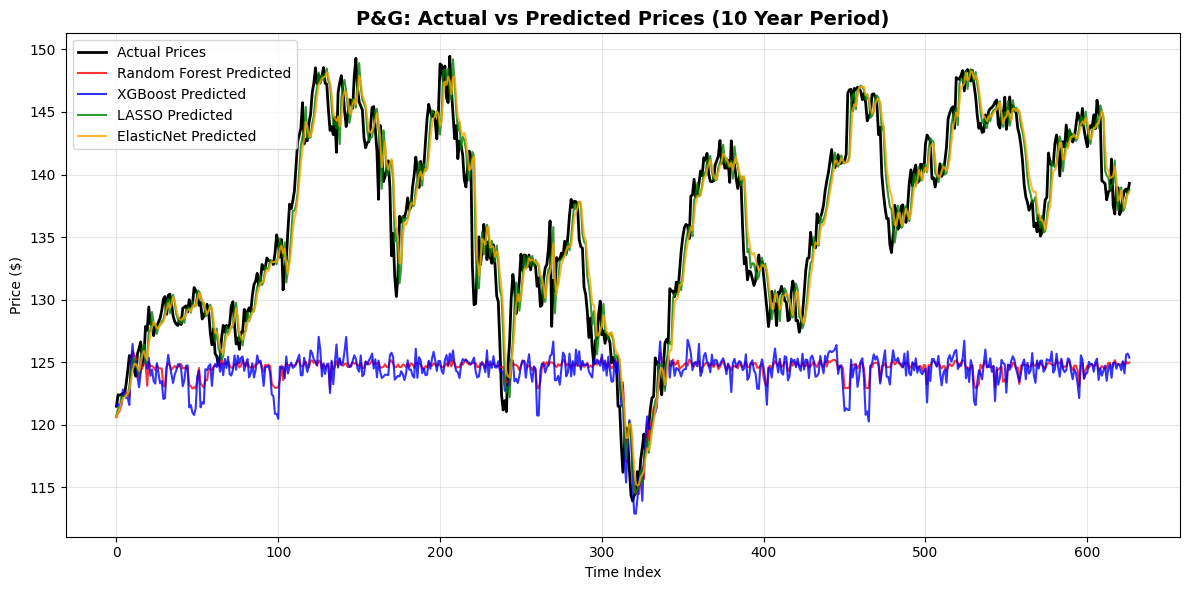

In [26]:
plt.figure(figsize=(12, 6))

# Plot actual prices
plt.plot(y_test_pg.to_numpy(), label='Actual Prices', color='black', linewidth=2)

# Plot predictions for each model
colors = ['red', 'blue', 'green', 'orange']
for i, (name, pred) in enumerate(predictions_pg.items()):
    plt.plot(pred, label=f'{name} Predicted', color=colors[i], alpha=0.8, linewidth=1.5)

plt.title('P&G: Actual vs Predicted Prices (10 Year Period)', fontsize=14, fontweight='bold')
plt.xlabel('Time Index')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()